# Step 1: Import Libraries

In [31]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (Scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# NLP (Natural Language Processing) with NLTK
import nltk
import re  
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are available (downloads if not already)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

print("✅ Libraries imported successfully")


[nltk_data] Downloading package stopwords to C:\Users\s
[nltk_data]     hayqa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\s
[nltk_data]     hayqa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\s
[nltk_data]     hayqa\AppData\Roaming\nltk_data...


✅ Libraries imported successfully


[nltk_data]   Package wordnet is already up-to-date!


# Step 2: Load the Dataset

In [2]:
df=pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


# Step 3: Exploratory Data Analysis (EDA)

# Data Structure

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49581,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [7]:
df.shape

(50000, 2)

In [8]:
df.dtypes

review       object
sentiment    object
dtype: object

# Check and remove duplicate reviews

In [9]:
duplicates = df.duplicated().sum()
print(f"\n Found {duplicates} duplicate reviews.")
df = df.drop_duplicates()
print(" Duplicates removed. New shape:", df.shape)


 Found 419 duplicate reviews.
 Duplicates removed. New shape: (49581, 2)


# Check for missing values

In [10]:
print("\n Missing Values:\n", df.isnull().sum())
# Drop rows with missing values if any
df = df.dropna()
print(" Missing values handled. New shape:", df.shape)


 Missing Values:
 review       0
sentiment    0
dtype: int64
 Missing values handled. New shape: (49581, 2)


# Visualize sentiment distribution

C:\Users\s hayqa\AppData\Local\Temp\ipykernel_6360\2478454634.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", palette="Set2")


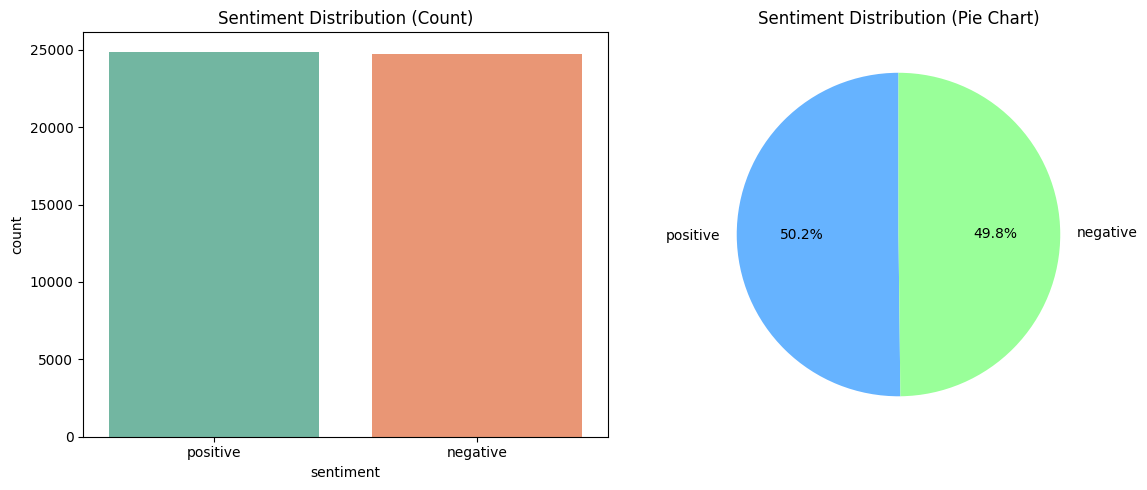

In [11]:
plt.figure(figsize=(12,5))

# Count Plot
plt.subplot(1,2,1)
sns.countplot(data=df, x="sentiment", palette="Set2")
plt.title("Sentiment Distribution (Count)")

# Pie Chart
plt.subplot(1,2,2)
df['sentiment'].value_counts().plot.pie(autopct="%1.1f%%", colors=["#66b3ff","#99ff99"], startangle=90)
plt.title("Sentiment Distribution (Pie Chart)")
plt.ylabel("")

plt.tight_layout()
plt.show()

# Step 4: Data Preprocessing

In [12]:
# 4.1 — Encode target: positive→1, negative→0 (case/space safe)
text_col = 'review'
label_col = 'sentiment'
df = df.copy()  # work on a copy
df[label_col] = (
    df[label_col]
    .astype(str).str.strip().str.lower()
    .map({'positive': 1, 'negative': 0})
)
# Drop rows where mapping failed
before = df.shape[0]
df = df.dropna(subset=[label_col])
after = df.shape[0]
print(f"Encoded labels. Dropped {before - after} rows with unknown labels.")


Encoded labels. Dropped 0 rows with unknown labels.


In [13]:
# 4.2 — Set up NLTK stopwords (download if missing)
import nltk
from nltk.corpus import stopwords

try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))


In [14]:
# 4.3 — Preprocessing function:
# - lowercasing
# - remove punctuation/special chars via regex
# - remove stopwords (NLTK)
def preprocess_text(text: str) -> str:
    # ensure string
    text = str(text)
    # lowercase
    text = text.lower()
    # keep only letters & spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    # collapse extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # remove stopwords
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)


In [15]:
# 4.4 — Apply preprocessing to all reviews
df['cleaned_review'] = df[text_col].apply(preprocess_text)

In [16]:
# 4.5 — Quick sanity checks
print("\nSample (original vs cleaned):")
print(df[[text_col, 'cleaned_review']].head(5))

print("\nLabel distribution after encoding:")
print(df[label_col].value_counts())

print("\nDone: df now has 'cleaned_review' and binary-encoded target.")



Sample (original vs cleaned):
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewers mentioned watching oz episode ho...  
1  wonderful little production br br filming tech...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake thinks zombie...  
4  petter mattei love time money visually stunnin...  

Label distribution after encoding:
sentiment
1    24884
0    24697
Name: count, dtype: int64

Done: df now has 'cleaned_review' and binary-encoded target.


In [17]:
# Make sure you have wordnet downloaded for lemmatization
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Initialize stemmer and lemmatizer
lemmatizer = WordNetLemmatizer()
# Apply Lemmatization ---
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Create new columns with stemmed/lemmatized versions
df['lemmatized_review'] = df['cleaned_review'].apply(lemmatize_text)

# Show comparison
print("\nSample comparison of preprocessing steps:")
print(df[['cleaned_review', 'lemmatized_review']].head())


[nltk_data] Downloading package wordnet to C:\Users\s
[nltk_data]     hayqa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\s
[nltk_data]     hayqa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Sample comparison of preprocessing steps:
                                      cleaned_review  \
0  one reviewers mentioned watching oz episode ho...   
1  wonderful little production br br filming tech...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake thinks zombie...   
4  petter mattei love time money visually stunnin...   

                                   lemmatized_review  
0  one reviewer mentioned watching oz episode hoo...  
1  wonderful little production br br filming tech...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  


# Step 5: Split the Data

In [19]:
# Use the lemmatized version for modeling (you can also try stemmed or cleaned)
X = df['lemmatized_review']   # Features (text data)
y = df['sentiment']           # Target (1 = positive, 0 = negative)

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 39664
Testing set size: 9917


# Step 6: Text Vectorization

In [21]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit on training data and transform both train & test sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)


TF-IDF Train Shape: (39664, 5000)
TF-IDF Test Shape: (9917, 5000)


# Step 7: Model Training

In [22]:
# Initialize the model
nb_model = MultinomialNB()

# Train (fit) the model on the training data
nb_model.fit(X_train_tfidf, y_train)

print("✅ Multinomial Naive Bayes model trained successfully!")


✅ Multinomial Naive Bayes model trained successfully!


# Step 8: Model Evaluation

In [23]:
#  Make predictions on the test set
y_pred = nb_model.predict(X_test_tfidf)

#  Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📊 Model Evaluation Results:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔄 Recall:    {recall:.4f}")
print(f"⚖️  F1-Score:  {f1:.4f}")

#  Full classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

📊 Model Evaluation Results:
✅ Accuracy:  0.8571
🎯 Precision: 0.8533
🔄 Recall:    0.8638
⚖️  F1-Score:  0.8585

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.86      4940
    Positive       0.85      0.86      0.86      4977

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



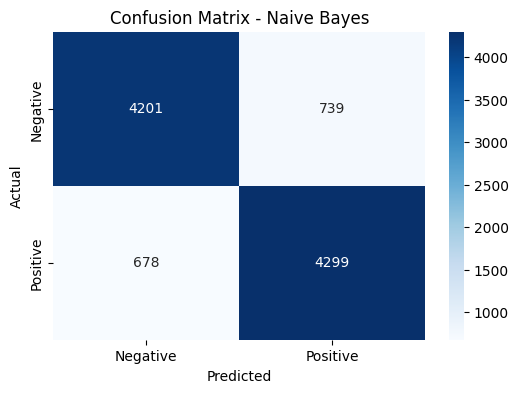

In [24]:
#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# ROC Curve

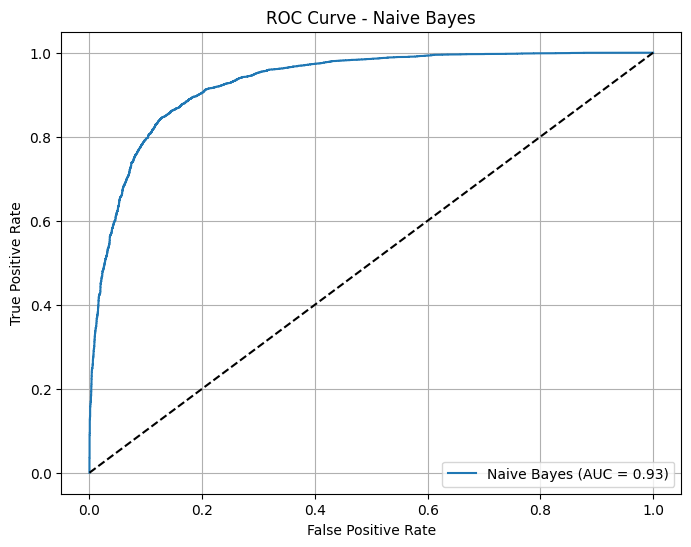

In [32]:
# --- ROC Curve ---
plt.figure(figsize=(8,6))

# Get predicted probabilities (only class=1 "Positive")
y_score = nb_model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random guess)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


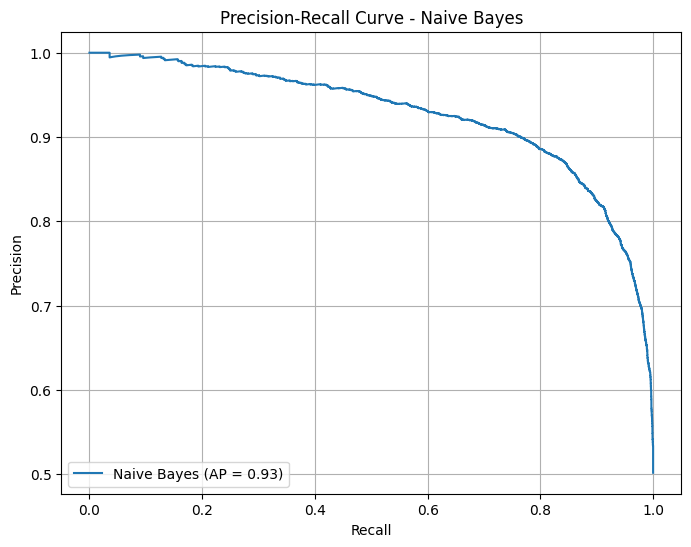

In [33]:
# --- Precision-Recall Curve ---
plt.figure(figsize=(8,6))

precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.plot(recall, precision, label=f"Naive Bayes (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Naive Bayes")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


# Step 9: Identify Important Words

In [35]:

# Redefine the TF-IDF vectorizer (from Step 6)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_review'])  # use your cleaned text column

#  Get feature names
feature_names = vectorizer.get_feature_names_out()

#  Get log probabilities from Naive Bayes model
word_probs = nb_model.feature_log_prob_

# Separate words contributing to negative (class 0) and positive (class 1)
top_neg_indices = np.argsort(word_probs[0])[-20:]
top_pos_indices = np.argsort(word_probs[1])[-20:]

print("🔹 Top 20 Words Indicating Negative Sentiment:")
for idx in top_neg_indices:
    print(f"{feature_names[idx]} ({word_probs[0][idx]:.2f})")

print("\n🔹 Top 20 Words Indicating Positive Sentiment:")
for idx in top_pos_indices:
    print(f"{feature_names[idx]} ({word_probs[1][idx]:.2f})")



🔹 Top 20 Words Indicating Negative Sentiment:
counter (-6.07)
active (-6.05)
seemingly (-6.03)
plays (-6.03)
stress (-6.00)
scientists (-5.98)
genre (-5.91)
maker (-5.91)
reality (-5.88)
channel (-5.84)
timing (-5.83)
worse (-5.81)
glover (-5.78)
eva (-5.75)
limits (-5.53)
backdrop (-5.53)
officers (-5.47)
fight (-5.01)
mountain (-4.68)
br (-4.22)

🔹 Top 20 Words Indicating Positive Sentiment:
maker (-6.09)
genre (-6.09)
bernard (-6.06)
likable (-6.05)
already (-6.04)
reality (-6.00)
sign (-5.97)
lover (-5.96)
channel (-5.88)
well (-5.88)
seemingly (-5.86)
timing (-5.78)
stress (-5.78)
limits (-5.75)
glover (-5.75)
grandfather (-5.67)
officers (-5.46)
fight (-4.91)
mountain (-4.91)
br (-4.31)


#  Visualization

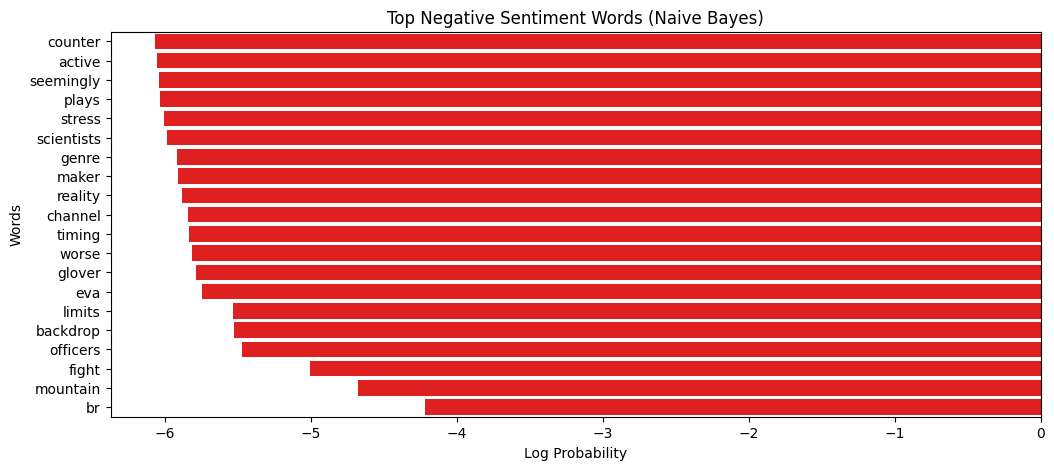

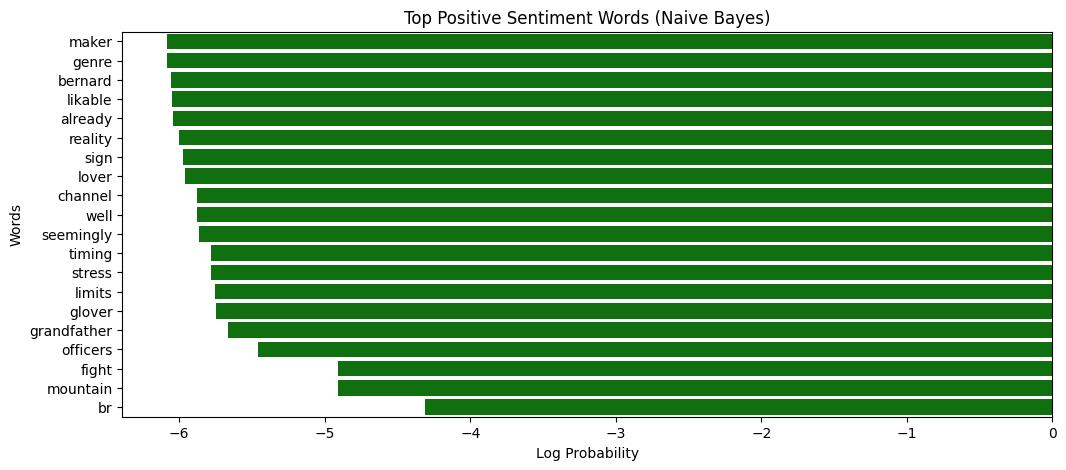

In [36]:
#  Visualization (optional): Bar plots for top words
plt.figure(figsize=(12, 5))

# Negative words
neg_words = [feature_names[i] for i in top_neg_indices]
neg_scores = [word_probs[0][i] for i in top_neg_indices]
sns.barplot(x=neg_scores, y=neg_words, color="red")
plt.title("Top Negative Sentiment Words (Naive Bayes)")
plt.xlabel("Log Probability")
plt.ylabel("Words")
plt.show()

# Positive words
plt.figure(figsize=(12, 5))
pos_words = [feature_names[i] for i in top_pos_indices]
pos_scores = [word_probs[1][i] for i in top_pos_indices]
sns.barplot(x=pos_scores, y=pos_words, color="green")
plt.title("Top Positive Sentiment Words (Naive Bayes)")
plt.xlabel("Log Probability")
plt.ylabel("Words")
plt.show()


# Step 10: Save Model and Vectorizer

In [37]:
import pickle

# ✅ Save the trained Naive Bayes model
with open("sentiment_nb_model.pkl", "wb") as model_file:
    pickle.dump(nb_model, model_file)

# ✅ Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)

print("✅ Model and Vectorizer saved successfully!")


✅ Model and Vectorizer saved successfully!


In [38]:
# Load the saved model
with open("sentiment_nb_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# Load the saved vectorizer
with open("tfidf_vectorizer.pkl", "rb") as vec_file:
    loaded_vectorizer = pickle.load(vec_file)

print("✅ Model and Vectorizer loaded successfully!")


✅ Model and Vectorizer loaded successfully!


# Model Testing

In [40]:
import re
import pickle

# ---------------- Load Model and Vectorizer ----------------
with open("sentiment_nb_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

with open("tfidf_vectorizer.pkl", "rb") as vec_file:
    loaded_vectorizer = pickle.load(vec_file)

# ---------------- Preprocess Function ----------------
def preprocess_review(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters & spaces
    return text

# ---------------- Test Function ----------------
def predict_sentiment(review):
    cleaned = preprocess_review(review)
    X_new = loaded_vectorizer.transform([cleaned])  # convert to vector
    prediction = loaded_model.predict(X_new)[0]     # get prediction
    
    if prediction == 1:
        return "👍 Positive Review"
    else:
        return "👎 Negative Review"

# ---------------- Example Test ----------------
test_review = "The movie was absolutely fantastic with brilliant acting!"
print("Review:", test_review)
print("Prediction:", predict_sentiment(test_review))



Review: The movie was absolutely fantastic with brilliant acting!
Prediction: 👍 Positive Review
